In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit 
from sklearn import svm
from pandas import ExcelWriter
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sbn
import timeit
import numpy as np
import re
import random


def xy_sets(line):
    X=None
    y=None
    indexes = map(int, re.findall('\d+', line))
    aux = False
    for i in indexes:
        if aux is False:
            X = scaled[i, :]
            y = target[i]
            aux = True
            continue
        X = np.vstack((X, scaled[i, :]))
        y = np.hstack((y, target[i]))
        
    return X, y, indexes


In [2]:
# parametrizacao geral
poly_models = np.linspace(0.001, 0.02, 20)
algo = ["opencv", "pb"]
tech = ['svm', 'knn', 'ann']

# parametrizacao ann
n_hidden = [2, 3]
alpha = [0.001, 0.01, 0.1, 1]
activation = ['identity', 'logistic', 'tanh']

# parametrizacao knn
kneighbors = np.arange(1, 11)

# parametrizacao svm
kers = ['linear', 'poly', 'rbf']

svm_best_para = []
knn_best_para = []
ann_best_para = []

# fst_part = read_csv('57_'+str(0.001)+'.csv', header=0, index_col=(0,1))
# scd_part = read_csv('54_'+str(0.001)+'.csv', header=0, index_col=(0,1))
# parts = [fst_part, scd_part]
# dataset = concat(parts)
# dataset
poly_models

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 ])

In [3]:
start = timeit.default_timer()

svm_accs_opencv = []
knn_accs_opencv = []
ann_accs_opencv = []

svm_best_para_opencv = []
knn_best_para_opencv = []
ann_best_para_opencv = []

svm_folds_accs_opencv = [np.array([]), [], []]
knn_folds_accs_opencv = [np.array([]), [], []]
ann_folds_accs_opencv = [np.array([]), [], []]


i = 0
for m in poly_models:
    m = round(m, 4)
    dataset = read_csv("{m}_{al}.csv".format(m=m, al="opencv"), header=0, index_col=(0,1))

    for t in tech:
        if t == 'svm':
            max_acc = 0
            max_folds_acc = np.zeros(20)
            best_para = None
            aux_svm = []
            for ker in kers:
                # pega apenas os valores contidos no dataset
                values = dataset.values

                # divide o dataset em data(input) e target(output)
                data = values[:, 1:] 
                target = values[:, 0]

                # normaliza as features
                # scaled = normalize(data, norm='max', axis=0)
                scaler = MinMaxScaler(feature_range=(0,1))                
                scaled = scaler.fit_transform(data)
                # scaled = np.concatenate((scaled, data[:, :4]), axis = 1)

                scores = np.zeros(20)
                col = np.array([])
                cont = 0
                sns = 0  # true negatives rate
                spf = 0  # true positives rate
                y_test_full = np.array([])
                y_cont_full = np.array([])

                file = open('combined_kf.txt', 'r')
                while cont < 20:

                    train_line = file.readline()
                    test_line = file.readline()

                    X_train, y_train, train_indexes = xy_sets(train_line)
                    X_test, y_test, test_indexes = xy_sets(test_line)

                    #create the SVM
                    clf = svm.SVC(gamma='auto', kernel=ker)
                    clf.fit(X_train, y_train)

                    y_pred = clf.predict(X_test)
                    scores[cont] = accuracy_score(y_test, y_pred)

                    y_test_full = np.hstack((y_test_full, y_test))
                    y_cont_full = np.hstack((y_cont_full, y_pred))

                    cont += 1

                file.close()

                conf_m = confusion_matrix(y_test_full, y_cont_full)

                acc = accuracy_score(y_test_full, y_cont_full)
                spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[1, 0])
                sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[0, 1])

                if acc > max_acc:
                    max_acc = acc
                    max_folds_acc = scores
                    best_para = (ker)

            svm_folds_accs_opencv[0] = np.hstack((svm_folds_accs_opencv[0], max_folds_acc))
            pm = [m] * 20
            svm_folds_accs_opencv[1] = svm_folds_accs_opencv[1] + pm
            tec = ['svm'] * 20
            svm_folds_accs_opencv[2] = svm_folds_accs_opencv[2] + tec

            svm_best_para_opencv.append(best_para)
            svm_accs_opencv.append(max_acc)
        elif t == 'knn':
            max_acc = 0
            max_folds_acc = np.zeros(20)
            best_para = None
            for k in kneighbors:
                # pega apenas os valores contidos no dataset
                values = dataset.values

                # divide o dataset em data(input) e target(output)
                data = values[:, 1:] 
                target = values[:, 0]

                # normaliza as features
                # scaled = normalize(data, norm='max', axis=0)
                scaler = MinMaxScaler(feature_range=(0,1))                
                scaled = scaler.fit_transform(data)

                # scaled = np.concatenate((scaled, data[:, :4]), axis = 1)


                scores = np.zeros(20)
                col = np.array([])
                cont = 0
                sns = 0  # true negatives rate
                spf = 0  # true positives rate
                y_test_full = np.array([])
                y_cont_full = np.array([])

                file = open('combined_kf.txt', 'r')
                while cont < 20:

                    train_line = file.readline()
                    test_line = file.readline()

                    X_train, y_train, train_indexes = xy_sets(train_line)
                    X_test, y_test, test_indexes = xy_sets(test_line)

                    classifier = KNeighborsClassifier(n_neighbors=k)  # classifier 
                    classifier.fit(X_train, y_train)
                    scores[cont] = classifier.score(X_test, y_test)
                    y_pred = classifier.predict(X_test)

                    y_test_full = np.hstack((y_test_full, y_test))
                    y_cont_full = np.hstack((y_cont_full, y_pred))

                    cont += 1

                file.close()

                conf_m = confusion_matrix(y_test_full, y_cont_full)

                acc = accuracy_score(y_test_full, y_cont_full)
                spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[1, 0])
                sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[0, 1])

                if acc > max_acc:
                    max_acc = acc
                    max_folds_acc = scores
                    best_para = (k)

            knn_folds_accs_opencv[0] = np.hstack((knn_folds_accs_opencv[0], max_folds_acc))
            pm = [m] * 20
            knn_folds_accs_opencv[1] = knn_folds_accs_opencv[1] + pm
            tec = [t] * 20
            knn_folds_accs_opencv[2] = knn_folds_accs_opencv[2] + tec

            knn_best_para_opencv.append(best_para)
            knn_accs_opencv.append(max_acc)

        elif t == 'ann':
            max_acc = 0
            max_folds_acc = np.zeros(20)
            best_para = None
            for n in n_hidden:
                for a in alpha:
                    for f in activation:
                        # pega apenas os valores contidos no dataset
                        values = dataset.values

                        # split data set into data(input) and target(output)
                        data = values[:, 1:] 
                        target = values[:, 0]

                        # normalize features
                        # scaled = normalize(data, norm='max', axis=0)
                        scaler = MinMaxScaler(feature_range=(0,1))                
                        scaled = scaler.fit_transform(data)

                        # scaled = np.concatenate((scaled, data[:, :4]), axis = 1)


                        scores = np.zeros(20)
                        col = np.array([])
                        cont = 0
                        sensitivity = 0  # true positives rate
                        specificity = 0  # true negatives rate
                        y_test_full = np.array([])
                        y_cont_full = np.array([])

                        file = open('combined_kf.txt', 'r')
                        while cont < 20:

                            train_line = file.readline()
                            test_line = file.readline()

                            X_train, y_train, train_indexes = xy_sets(train_line)
                            X_test, y_test, test_indexes = xy_sets(test_line)

                            classifier = MLPClassifier(hidden_layer_sizes=(n,), activation=f, solver='lbfgs', 
                                                        alpha=a, random_state=11, verbose=False, max_iter=1500)  # classifier 
                            classifier.fit(X_train, y_train)
                            scores[cont] = classifier.score(X_test, y_test)
                            y_pred = classifier.predict(X_test)

                            y_test_full = np.hstack((y_test_full, y_test))
                            y_cont_full = np.hstack((y_cont_full, y_pred))

                            cont += 1

                        file.close()

                        conf_m = confusion_matrix(y_test_full, y_cont_full)

                        acc = accuracy_score(y_test_full, y_cont_full)
                        spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[1, 0])
                        sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[0, 1])

                        if acc > max_acc:
                            max_acc = acc
                            max_folds_acc = scores   
                            best_para = (n, a, f)  # multiplier and best parameters


            ann_folds_accs_opencv[0] = np.hstack((ann_folds_accs_opencv[0], max_folds_acc))
            pm = [m] * 20
            ann_folds_accs_opencv[1] = ann_folds_accs_opencv[1] + pm
            tec = [t] * 20
            ann_folds_accs_opencv[2] = ann_folds_accs_opencv[2] + tec

            ann_best_para_opencv.append(best_para)
            ann_accs_opencv.append(max_acc)
        else:
            print('qq ta conteceno? nem deveria chegar aqui')
        i += 1
stop = timeit.default_timer()
print('Time: ', stop - start) 

print(svm_best_para_opencv)
print()
print()
print(knn_best_para_opencv)
print()
print()
print(ann_best_para_opencv)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase t

Time:  266.680377
['rbf', 'linear', 'linear', 'linear', 'linear', 'linear', 'rbf', 'linear', 'linear', 'rbf', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'rbf', 'rbf', 'linear', 'rbf']


[8, 8, 8, 3, 3, 6, 6, 8, 10, 1, 5, 5, 5, 8, 5, 7, 9, 7, 9, 7]


[(3, 0.1, 'tanh'), (2, 1, 'logistic'), (2, 0.1, 'tanh'), (2, 0.1, 'tanh'), (2, 0.1, 'logistic'), (2, 0.01, 'logistic'), (2, 0.1, 'identity'), (2, 1, 'logistic'), (3, 0.01, 'tanh'), (2, 1, 'logistic'), (3, 1, 'tanh'), (2, 1, 'identity'), (2, 1, 'identity'), (2, 1, 'identity'), (2, 0.01, 'identity'), (2, 0.1, 'identity'), (2, 0.001, 'tanh'), (2, 1, 'tanh'), (2, 0.01, 'tanh'), (2, 1, 'tanh')]


In [3]:
start = timeit.default_timer()

svm_accs_pb = []
knn_accs_pb = []
ann_accs_pb = []

svm_best_para_pb = []
knn_best_para_pb = []
ann_best_para_pb = []

svm_folds_accs_pb = [np.array([]), [], []]
knn_folds_accs_pb = [np.array([]), [], []]
ann_folds_accs_pb = [np.array([]), [], []]


i = 0
for m in poly_models:
    m = round(m, 4)
    dataset = read_csv("{m}_{al}.csv".format(m=m, al="pb"), header=0, index_col=(0,1))

    for t in tech:
        if t == 'svm':
            max_acc = 0
            max_folds_acc = np.zeros(20)
            best_para = None
            aux_svm = []
            for ker in kers:
                # pega apenas os valores contidos no dataset
                values = dataset.values

                # divide o dataset em data(input) e target(output)
                data = values[:, 1:] 
                target = values[:, 0]

                # normaliza as features
                scaled = normalize(data[:, :3], norm='max', axis=0)
                scaled = np.concatenate((scaled, data[:, :4]), axis = 1)

                scores = np.zeros(20)
                col = np.array([])
                cont = 0
                sns = 0  # true negatives rate
                spf = 0  # true positives rate
                y_test_full = np.array([])
                y_cont_full = np.array([])

                file = open('combined_kf.txt', 'r')
                while cont < 20:

                    train_line = file.readline()
                    test_line = file.readline()

                    X_train, y_train, train_indexes = xy_sets(train_line)
                    X_test, y_test, test_indexes = xy_sets(test_line)

                    #create the SVM
                    clf = svm.SVC(gamma='auto', kernel=ker)
                    clf.fit(X_train, y_train)

                    y_pred = clf.predict(X_test)
                    scores[cont] = accuracy_score(y_test, y_pred)

                    y_test_full = np.hstack((y_test_full, y_test))
                    y_cont_full = np.hstack((y_cont_full, y_pred))

                    cont += 1

                file.close()

                conf_m = confusion_matrix(y_test_full, y_cont_full)

                acc = accuracy_score(y_test_full, y_cont_full)
                spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[1, 0])
                sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[0, 1])

                if acc > max_acc:
                    max_acc = acc
                    max_folds_acc = scores
                    best_para = (ker)

            svm_folds_accs_pb[0] = np.hstack((svm_folds_accs_pb[0], max_folds_acc))
            pm = [m] * 20
            svm_folds_accs_pb[1] = svm_folds_accs_pb[1] + pm
            tec = ['svm'] * 20
            svm_folds_accs_pb[2] = svm_folds_accs_pb[2] + tec

            svm_best_para_pb.append(best_para)
            svm_accs_pb.append(max_acc)
        elif t == 'knn':
            max_acc = 0
            max_folds_acc = np.zeros(20)
            best_para = None
            for k in kneighbors:
                # pega apenas os valores contidos no dataset
                values = dataset.values

                # divide o dataset em data(input) e target(output)
                data = values[:, 1:] 
                target = values[:, 0]

                # normaliza as features
                scaled = normalize(data[:, :3], norm='max', axis=0)
                scaled = np.concatenate((scaled, data[:, :4]), axis = 1)

                scores = np.zeros(20)
                col = np.array([])
                cont = 0
                sns = 0  # true negatives rate
                spf = 0  # true positives rate
                y_test_full = np.array([])
                y_cont_full = np.array([])

                file = open('combined_kf.txt', 'r')
                while cont < 20:

                    train_line = file.readline()
                    test_line = file.readline()

                    X_train, y_train, train_indexes = xy_sets(train_line)
                    X_test, y_test, test_indexes = xy_sets(test_line)

                    classifier = KNeighborsClassifier(n_neighbors=k)  # classifier 
                    classifier.fit(X_train, y_train)
                    scores[cont] = classifier.score(X_test, y_test)
                    y_pred = classifier.predict(X_test)

                    y_test_full = np.hstack((y_test_full, y_test))
                    y_cont_full = np.hstack((y_cont_full, y_pred))

                    cont += 1

                file.close()

                conf_m = confusion_matrix(y_test_full, y_cont_full)

                acc = accuracy_score(y_test_full, y_cont_full)
                spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[1, 0])
                sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[0, 1])

                if acc > max_acc:
                    max_acc = acc
                    max_folds_acc = scores
                    best_para = (k)

            knn_folds_accs_pb[0] = np.hstack((knn_folds_accs_pb[0], max_folds_acc))
            pm = [m] * 20
            knn_folds_accs_pb[1] = knn_folds_accs_pb[1] + pm
            tec = [t] * 20
            knn_folds_accs_pb[2] = knn_folds_accs_pb[2] + tec

            knn_best_para_pb.append(best_para)
            knn_accs_pb.append(max_acc)

        elif t == 'ann':
            max_acc = 0
            max_folds_acc = np.zeros(20)
            best_para = None
            for n in n_hidden:
                for a in alpha:
                    for f in activation:
                        # pega apenas os valores contidos no dataset
                        values = dataset.values

                        # split data set into data(input) and target(output)
                        data = values[:, 1:] 
                        target = values[:, 0]

                        # normalize features
                        scaled = normalize(data[:, :3], norm='max', axis=0)
                        scaled = np.concatenate((scaled, data[:, :4]), axis = 1)

                        scores = np.zeros(20)
                        col = np.array([])
                        cont = 0
                        sensitivity = 0  # true positives rate
                        specificity = 0  # true negatives rate
                        y_test_full = np.array([])
                        y_cont_full = np.array([])

                        file = open('combined_kf.txt', 'r')
                        while cont < 20:

                            train_line = file.readline()
                            test_line = file.readline()

                            X_train, y_train, train_indexes = xy_sets(train_line)
                            X_test, y_test, test_indexes = xy_sets(test_line)

                            classifier = MLPClassifier(hidden_layer_sizes=(n,), activation=f, solver='lbfgs', 
                                                        alpha=a, random_state=11, verbose=False, max_iter=2000)  # classifier 
                            classifier.fit(X_train, y_train)
                            scores[cont] = classifier.score(X_test, y_test)
                            y_pred = classifier.predict(X_test)

                            y_test_full = np.hstack((y_test_full, y_test))
                            y_cont_full = np.hstack((y_cont_full, y_pred))

                            cont += 1

                        file.close()

                        conf_m = confusion_matrix(y_test_full, y_cont_full)

                        acc = accuracy_score(y_test_full, y_cont_full)
                        spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[1, 0])
                        sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[0, 1])

                        if acc > max_acc:
                            max_acc = acc
                            max_folds_acc = scores   
                            best_para = (n, a, f)  # multiplier and best parameters


            ann_folds_accs_pb[0] = np.hstack((ann_folds_accs_pb[0], max_folds_acc))
            pm = [m] * 20
            ann_folds_accs_pb[1] = ann_folds_accs_pb[1] + pm
            tec = [t] * 20
            ann_folds_accs_pb[2] = ann_folds_accs_pb[2] + tec

            ann_best_para_pb.append(best_para)
            ann_accs_pb.append(max_acc)
        else:
            print('qq ta conteceno? nem deveria chegar aqui')
        i += 1
stop = timeit.default_timer()
print('Time: ', stop - start) 

print(svm_best_para_pb)
print()
print()
print(knn_best_para_pb)
print()
print()
print(ann_best_para_pb)

Time:  171.2665619
['rbf', 'rbf', 'linear', 'linear', 'linear', 'poly', 'linear', 'linear', 'linear', 'linear', 'linear', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf']


[3, 1, 9, 9, 1, 8, 8, 6, 3, 5, 5, 7, 8, 3, 3, 9, 7, 3, 7, 5]


[(2, 0.1, 'logistic'), (2, 0.001, 'identity'), (2, 0.1, 'logistic'), (2, 0.001, 'logistic'), (2, 0.1, 'logistic'), (3, 0.001, 'identity'), (2, 0.001, 'identity'), (2, 0.1, 'tanh'), (2, 0.001, 'tanh'), (2, 0.1, 'tanh'), (2, 1, 'tanh'), (2, 0.001, 'logistic'), (3, 0.01, 'tanh'), (2, 0.01, 'tanh'), (2, 1, 'tanh'), (3, 0.001, 'tanh'), (2, 0.001, 'tanh'), (2, 0.001, 'logistic'), (2, 0.001, 'logistic'), (3, 0.001, 'tanh')]


In [3]:
svm_best_para_pb = ['rbf', 'rbf', 'linear', 'linear', 'linear', 'poly', 'linear', 'linear', 'linear', 'linear', 'linear', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf']
knn_best_para_pb = [3, 1, 9, 9, 1, 8, 8, 6, 3, 5, 5, 7, 8, 3, 3, 9, 7, 3, 7, 5]
ann_best_para_pb = [(2, 0.1, 'logistic'), (2, 0.001, 'identity'), (2, 0.1, 'logistic'), (2, 0.001, 'logistic'), (2, 0.1, 'logistic'), (3, 0.001, 'identity'), (2, 0.001, 'identity'), (2, 0.1, 'tanh'), (2, 0.001, 'tanh'), (2, 0.1, 'tanh'), (2, 1, 'tanh'), (2, 0.001, 'logistic'), (3, 0.01, 'tanh'), (2, 0.01, 'tanh'), (2, 1, 'tanh'), (3, 0.001, 'tanh'), (2, 0.001, 'tanh'), (2, 0.001, 'logistic'), (2, 0.001, 'logistic'), (3, 0.001, 'tanh')]

In [11]:
start = timeit.default_timer()

svm_avg_accs = []
svm_avg_aucs = []

svm_folds_accs = [np.array([]), [], []]

max_acc = 0
max_auc = 0

# svm_accs_poly = np.zeros((poly_models.shape[0], 100))
# svm_auc_poly = np.zeros((poly_models.shape[0], 100))

svm_accs_poly = np.zeros(100)
svm_auc_poly = np.zeros(100)

i = 3

# for i in range(poly_models.shape[0]):  # for each epsilon 
m = round(poly_models[i], 4)
dataset = read_csv("{m}_{al}.csv".format(m=m, al="pb"), header=0, index_col=(0,1))
# test holdout 100 for the best set of parameters 

ker = svm_best_para_pb[i]  # best set of parameters

values = dataset.values  # only gets the values within the dataset

# divide the dataset into data(input) and target(output)
data = values[:, 1:] 
target = values[:, 0]

scaler = MinMaxScaler(feature_range=(0,1))                
scaled = scaler.fit_transform(data)

scores = np.zeros(20)
col = np.array([])
cont = 0
acc = 0
sns = 0  # true negatives rate
spf = 0  # true positives rate

y_test_full = np.array([])
y_pred_full = np.array([])

clf = svm.SVC(gamma='auto', kernel=ker) # create the SVM

ss = ShuffleSplit(n_splits=100, test_size=10, random_state=42)

j = 0

for train_index, test_index in ss.split(data):
#     print("%s %s" % (train_index, test_index))

    X_train = data[train_index, :]
    y_train = target[train_index]

    X_test = data[test_index, :]
    y_test = target[test_index]

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    scores[cont] = accuracy_score(y_test, y_pred)

    y_test_full = np.hstack((y_test_full, y_test))
    y_pred_full = np.hstack((y_pred_full, y_pred))

    conf_m = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[0, 1])
    spf = conf_m[1, 1]/(conf_m[1, 1]+conf_m[1, 0])

    svm_accs_poly[j] = acc
    svm_auc_poly[j] = (sns + spf)/2

    svm_folds_accs[0] = np.hstack((svm_folds_accs[0], acc))
    pm = [m]
    svm_folds_accs[1] = svm_folds_accs[1] + pm
    tec = ['svm']
    svm_folds_accs[2] = svm_folds_accs[2] + tec

    j += 1

conf_m_full = confusion_matrix(y_test_full, y_pred_full)
spf = conf_m_full[0, 0]/(conf_m_full[0, 0]+conf_m_full[0, 1])
sns = conf_m_full[1, 1]/(conf_m_full[1, 1]+conf_m_full[1, 0])

avg_auc = (sns + spf)/2
avg_acc = accuracy_score(y_test_full, y_pred_full)
svm_avg_accs.append(avg_acc)
svm_avg_aucs.append(avg_auc)

if avg_acc > max_acc:
    max_acc = avg_acc
if avg_auc > max_auc:
    max_auc = avg_auc
        
    
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(max_acc)
print(max_auc)
print(svm_best_para_pb[i])
print(poly_models[i])


svm_accs_poly

Time:  0.101390600000002
0.84
0.8439913500154463
linear
0.004


array([0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.7,
       0.8, 1. , 0.8, 0.9, 0.9, 0.8, 0.5, 0.7, 0.7, 0.8, 0.6, 0.8, 1. ,
       0.9, 1. , 0.9, 0.7, 0.9, 0.6, 0.8, 1. , 1. , 0.8, 0.9, 0.9, 0.7,
       0.7, 0.9, 0.9, 0.9, 1. , 0.7, 0.8, 0.9, 0.8, 0.8, 1. , 1. , 0.8,
       0.8, 1. , 0.7, 0.9, 0.8, 0.9, 0.6, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9,
       1. , 0.9, 0.6, 0.9, 0.8, 0.9, 0.8, 0.7, 0.9, 0.9, 1. , 0.8, 1. ,
       0.8, 0.9, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.7, 0.9, 1. , 0.7, 1. ,
       0.8, 0.7, 1. , 0.8, 0.9, 1. , 0.9, 0.9, 0.8])

In [12]:
start = timeit.default_timer()

knn_avg_accs = []
knn_avg_aucs = []

knn_folds_accs = [np.array([]), [], []]

# knn_accs_poly = np.zeros((poly_models.shape[0], 100))
# knn_auc_poly = np.zeros((poly_models.shape[0], 100))

knn_accs_poly = np.zeros(100)
knn_auc_poly = np.zeros(100)

max_acc = 0
max_auc = 0

i = 6

# for i in range(poly_models.shape[0]):  # for each epsilon 
m = round(poly_models[i], 4)
dataset = read_csv("{m}_{al}.csv".format(m=m, al="pb"), header=0, index_col=(0,1))
# test holdout 100 for the best set of parameters 

k = knn_best_para_pb[i]  # best set of parameters

values = dataset.values  # only gets the values within the dataset

# divide the dataset into data(input) and target(output)
data = values[:, 1:] 
target = values[:, 0]

scaler = MinMaxScaler(feature_range=(0,1))                
scaled = scaler.fit_transform(data)

scores = np.zeros(20)
col = np.array([])
cont = 0
acc = 0
sns = 0  # true negatives rate
spf = 0  # true positives rate

y_test_full = np.array([])
y_pred_full = np.array([])

clf = KNeighborsClassifier(n_neighbors=k)  # classifier 

ss = ShuffleSplit(n_splits=100, test_size=10, random_state=3)

j = 0

for train_index, test_index in ss.split(data):
#     print("%s %s" % (train_index, test_index))

    X_train = data[train_index, :]
    y_train = target[train_index]

    X_test = data[test_index, :]
    y_test = target[test_index]

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    scores[cont] = accuracy_score(y_test, y_pred)

    y_test_full = np.hstack((y_test_full, y_test))
    y_pred_full = np.hstack((y_pred_full, y_pred))

    conf_m = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[0, 1])
    sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[1, 0])

    knn_accs_poly[j] = acc
    knn_auc_poly[j] = (sns + spf)/2

    knn_folds_accs[0] = np.hstack((knn_folds_accs[0], acc))
    pm = [m]
    knn_folds_accs[1] = knn_folds_accs[1] + pm
    tec = ['knn']
    knn_folds_accs[2] = knn_folds_accs[2] + tec

    j += 1

conf_m_full = confusion_matrix(y_test_full, y_pred_full)    
spf = conf_m_full[0, 0]/(conf_m_full[0, 0]+conf_m_full[0, 1])
sns = conf_m_full[1, 1]/(conf_m_full[1, 1]+conf_m_full[1, 0])

avg_auc = (sns + spf)/2
avg_acc = accuracy_score(y_test_full, y_pred_full)
knn_avg_accs.append(avg_acc)
knn_avg_aucs.append(avg_auc)

if avg_acc > max_acc:
    max_acc = avg_acc
if avg_auc > max_auc:
    max_auc = avg_auc

stop = timeit.default_timer()
print('Time: ', stop - start) 
print(max_acc)
print(max_auc)
print(knn_best_para_pb[i])
print(poly_models[i])


knn_accs_poly

Time:  0.14492209999997385
0.847
0.843375547878524
8
0.007


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in longlong_scalars


array([0.8, 0.5, 0.9, 0.9, 0.9, 0.8, 0.7, 1. , 0.8, 1. , 0.9, 0.8, 0.7,
       0.6, 0.9, 0.9, 0.8, 1. , 0.9, 1. , 0.9, 0.8, 1. , 0.8, 0.9, 0.9,
       0.9, 0.7, 0.8, 1. , 0.9, 0.9, 0.9, 0.8, 0.9, 0.9, 0.9, 0.8, 1. ,
       0.8, 0.9, 0.8, 0.9, 1. , 0.9, 0.7, 1. , 0.7, 0.7, 0.7, 0.8, 0.8,
       0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9,
       0.9, 0.9, 1. , 0.9, 0.8, 1. , 0.5, 0.8, 0.6, 0.9, 0.6, 0.7, 0.7,
       0.9, 0.8, 0.9, 0.7, 0.9, 0.8, 0.7, 0.7, 1. , 0.9, 0.9, 0.7, 0.8,
       0.8, 0.9, 1. , 1. , 0.9, 0.8, 0.9, 0.9, 1. ])

In [13]:
start = timeit.default_timer()

ann_avg_accs = []
ann_avg_aucs = []

ann_folds_accs = [np.array([]), [], []]

# ann_accs_poly = np.zeros((poly_models.shape[0], 100))
# ann_auc_poly = np.zeros((poly_models.shape[0], 100))

ann_accs_poly = np.zeros(100)
ann_auc_poly = np.zeros(100)

max_acc = 0
max_auc = 0

i = 1

# for i in range(poly_models.shape[0]):  # for each epsilon 
m = round(poly_models[i], 4)
dataset = read_csv("{m}_{al}.csv".format(m=m, al="pb"), header=0, index_col=(0,1))
# test holdout 100 for the best set of parameters 

n, a, f = ann_best_para_pb[i]  # best set of parameters

values = dataset.values  # only gets the values within the dataset

# divide the dataset into data(input) and target(output)
data = values[:, 1:] 
target = values[:, 0]

scaler = MinMaxScaler(feature_range=(0,1))                
scaled = scaler.fit_transform(data)

scores = np.zeros(20)
col = np.array([])
cont = 0
acc = 0
sns = 0  # true negatives rate
spf = 0  # true positives rate

y_test_full = np.array([])
y_pred_full = np.array([])

clf = MLPClassifier(hidden_layer_sizes=(n,), solver='lbfgs', activation=f, 
                    alpha=a, random_state=11, verbose=False, max_iter=3000)  # classifier

ss = ShuffleSplit(n_splits=100, test_size=10, random_state=42)

j = 0

for train_index, test_index in ss.split(data):
#     print("%s %s" % (train_index, test_index))

    X_train = data[train_index, :]
    y_train = target[train_index]

    X_test = data[test_index, :]
    y_test = target[test_index]

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    scores[cont] = accuracy_score(y_test, y_pred)

    y_test_full = np.hstack((y_test_full, y_test))
    y_pred_full = np.hstack((y_pred_full, y_pred))

    conf_m = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[0, 1])
    sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[1, 0])

    ann_accs_poly[j] = acc
    ann_auc_poly[j] = (sns + spf)/2

    ann_folds_accs[0] = np.hstack((ann_folds_accs[0], acc))
    pm = [m]
    ann_folds_accs[1] = ann_folds_accs[1] + pm
    tec = ['ann']
    ann_folds_accs[2] = ann_folds_accs[2] + tec

    j += 1

conf_m_full = confusion_matrix(y_test_full, y_pred_full)
spf = conf_m_full[0, 0]/(conf_m_full[0, 0]+conf_m_full[0, 1])
sns = conf_m_full[1, 1]/(conf_m_full[1, 1]+conf_m_full[1, 0])

avg_auc = (sns + spf)/2
avg_acc = accuracy_score(y_test_full, y_pred_full)
ann_avg_accs.append(avg_acc)
ann_avg_aucs.append(avg_auc)

if avg_acc > max_acc:
    max_acc = avg_acc
if avg_auc > max_auc:
    max_auc = avg_auc

stop = timeit.default_timer()
print('Time: ', stop - start) 
print(max_acc)
print(max_auc)
print(ann_best_para_pb[i])
print(poly_models[i])


ann_accs_poly

Time:  8.275672499999985
0.849
0.8471321182164555
(2, 0.001, 'identity')
0.002


array([1. , 0.9, 0.9, 0.8, 0.9, 0.8, 0.7, 0.8, 0.8, 0.9, 0.8, 0.9, 0.8,
       0.9, 1. , 0.9, 0.9, 0.9, 0.9, 0.5, 0.7, 0.8, 0.8, 0.8, 0.8, 0.9,
       0.9, 1. , 0.9, 0.8, 0.9, 0.7, 0.9, 0.9, 1. , 0.9, 0.8, 0.8, 0.6,
       0.8, 0.9, 0.9, 1. , 1. , 0.8, 0.8, 0.9, 0.7, 0.7, 1. , 1. , 0.7,
       0.9, 0.9, 0.6, 0.9, 0.8, 1. , 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.7,
       0.9, 0.9, 0.8, 0.8, 0.8, 1. , 0.7, 0.8, 0.9, 1. , 0.9, 0.9, 1. ,
       0.8, 1. , 0.8, 0.9, 0.7, 0.7, 0.9, 1. , 0.9, 1. , 0.8, 0.6, 0.9,
       0.6, 0.7, 0.9, 0.9, 0.9, 1. , 0.8, 0.8, 0.8])

In [39]:
ttest = stats.ttest_ind(ann_accs_poly, svm_accs_poly)
ttest[1]

0.5630751529181333

In [40]:
ttest = stats.ttest_ind(knn_accs_poly, svm_accs_poly)
ttest[1]

0.6580706447129714

In [41]:
ttest = stats.ttest_ind(ann_accs_poly, knn_accs_poly)
ttest[1]

0.897474351013955

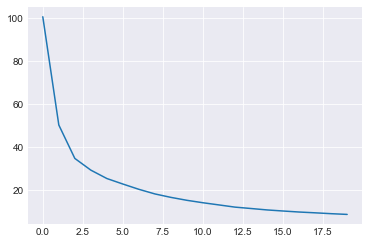

In [136]:
f = open("n_points.txt", "r")
p = f.read()
p = p.split("\n", 20)
p.pop()
p = list(map(float, p))
plt.plot(p)
plt.show()

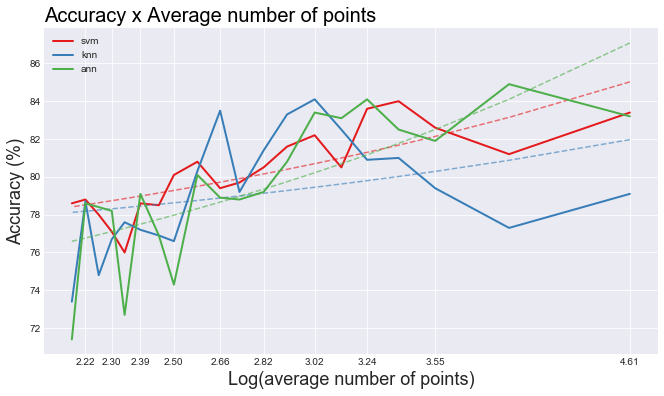

In [137]:
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.close()
plt.figure(figsize=(11, 6))

# pm_labels = np.arange(0.1, 2.1, 0.1)
pm_labels = p
pm_labels = np.log(pm_labels)
pm_labels = [round(elem, 2) for elem in pm_labels] 

ax = plt.gca()
    
# plt.xticks(pm_labels, fontsize=12)

svm_accs = [i * 100 for i in svm_avg_accs]
knn_accs = [j * 100 for j in knn_avg_accs]
ann_accs = [m * 100 for m in ann_avg_accs]

num = 0
plt.plot(pm_labels, svm_accs, marker='', color=palette(num), linewidth=2, alpha=1, label='svm')
z = np.polyfit(pm_labels, svm_accs, 1)
p = np.poly1d(z)
plt.plot(pm_labels, p(pm_labels), 'r--', color=palette(num), alpha=0.6)

num = 1
plt.plot(pm_labels, knn_accs, marker='', color=palette(num), linewidth=2, alpha=1, label='knn')
z = np.polyfit(pm_labels, knn_accs, 1)
p = np.poly1d(z)
plt.plot(pm_labels, p(pm_labels), 'r--', color=palette(num), alpha=0.6)

num = 2
plt.plot(pm_labels, ann_accs, marker='', color=palette(num), linewidth=2, alpha=1, label='ann')
z = np.polyfit(pm_labels, ann_accs, 1)
p = np.poly1d(z)
plt.plot(pm_labels, p(pm_labels), 'r--', color=palette(num), alpha=0.6)

# Add legend
plt.legend(loc=2, ncol=1)

p = []
cont = 0

for i in pm_labels:
    if cont % 2 == 0:
        p.append(i)
    cont += 1

ax.set_xscale("log")
ax.set_xticks(p)

ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())

# plt.locator_params(axis='x')

plt.title('Accuracy x Average number of points', loc='left', fontsize=20, fontweight=0, color='black')
plt.xlabel("Log(average number of points)", fontsize=18)
plt.ylabel("Accuracy (%)", fontsize=18)

plt.savefig('acc_100h_tline_pb', dpi=150)

plt.show()

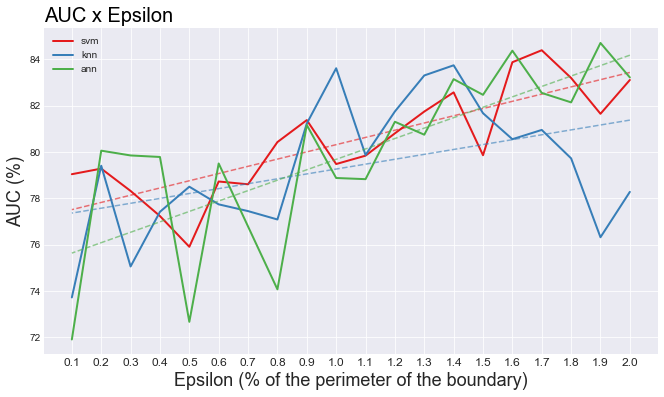

In [138]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.figure(figsize=(11, 6))

pm_labels = np.arange(2.0, 0, -0.1)

plt.xticks(pm_labels, fontsize=12) 

svm_aucs = [i * 100 for i in svm_avg_aucs]
knn_aucs = [j * 100 for j in knn_avg_aucs]
ann_aucs = [m * 100 for m in ann_avg_aucs]

num = 0
plt.plot(pm_labels, svm_aucs, marker='', color=palette(num), linewidth=2, alpha=1, label='svm')
z = np.polyfit(pm_labels, svm_aucs, 1)
p = np.poly1d(z)
plt.plot(pm_labels, p(pm_labels), 'r--', color=palette(num), alpha=0.6)

num = 1
plt.plot(pm_labels, knn_aucs, marker='', color=palette(num), linewidth=2, alpha=1, label='knn')
z = np.polyfit(pm_labels, knn_aucs, 1)
p = np.poly1d(z)
plt.plot(pm_labels, p(pm_labels), 'r--', color=palette(num), alpha=0.6)

num = 2
plt.plot(pm_labels, ann_aucs, marker='', color=palette(num), linewidth=2, alpha=1, label='ann')
z = np.polyfit(pm_labels, ann_aucs, 1)
p = np.poly1d(z)
plt.plot(pm_labels, p(pm_labels), 'r--', color=palette(num), alpha=0.6)

# Add legend
plt.legend(loc=2, ncol=1)

plt.title('AUC x Epsilon', loc='left', fontsize=20, fontweight=0, color='black')
plt.xlabel("Epsilon (% of the perimeter of the boundary)", fontsize=18)
plt.ylabel("AUC (%)", fontsize=18)

plt.savefig('auc_100h_tline_pb', dpi=150)

plt.show()

In [ ]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.figure(figsize=(11, 6))

pm_labels = np.arange(0.1, 2.1, 0.1)

plt.xticks(pm_labels, fontsize=12) 

svm_avg_accs = [i * 100 for i in svm_avg_accs]
knn_avg_accs = [j * 100 for j in knn_avg_accs]
ann_avg_accs = [m * 100 for m in ann_avg_accs]

num = 0
plt.plot(pm_labels, svm_avg_accs, marker='', color=palette(num), linewidth=2, alpha=1, label='svm')
z = np.polyfit(pm_labels, svm_avg_accs, 1)
p = np.poly1d(z)
plt.plot(pm_labels, p(pm_labels), 'r--', color=palette(num), alpha=0.6)

num = 1
plt.plot(pm_labels, knn_avg_accs, marker='', color=palette(num), linewidth=2, alpha=1, label='knn')
z = np.polyfit(pm_labels, knn_avg_accs, 1)
p = np.poly1d(z)
plt.plot(pm_labels, p(pm_labels), 'r--', color=palette(num), alpha=0.6)

num = 2
plt.plot(pm_labels, ann_avg_accs, marker='', color=palette(num), linewidth=2, alpha=1, label='ann')
z = np.polyfit(pm_labels, ann_avg_accs, 1)
p = np.poly1d(z)
plt.plot(pm_labels, p(pm_labels), 'r--', color=palette(num), alpha=0.6)

# Add legend
plt.legend(loc=2, ncol=1)

plt.title('Accuracy x Epsilon', loc='left', fontsize=20, fontweight=0, color='black')
plt.xlabel("Epsilon (% of the perimeter of the boundary)", fontsize=18)
plt.ylabel("Accuracy (%)", fontsize=18)

plt.savefig('acc_100h_tline_pb', dpi=150)

plt.show()

In [9]:
fst = DataFrame(svm_folds_accs)
snd = DataFrame(knn_folds_accs)
trd = DataFrame(ann_folds_accs)

df = concat([fst, snd, trd], axis=1, ignore_index=True)
df = df.T
df.columns = ['accuracy', 'poly_mod', 'classifier']

df

,accuracy,poly_mod,classifier
0,0.8,0.001,svm
1,0.9,0.001,svm
2,0.8,0.001,svm
3,0.8,0.001,svm
4,0.8,0.001,svm
5,0.8,0.001,svm
6,0.9,0.001,svm
7,0.8,0.001,svm
8,0.8,0.001,svm
9,0.9,0.001,svm


[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]


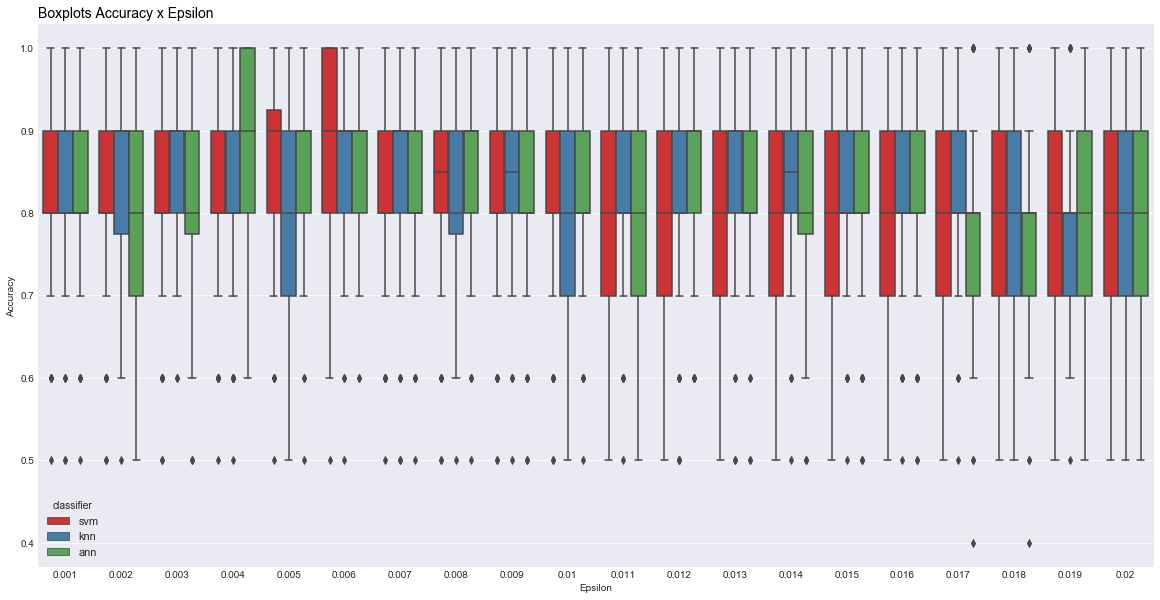

In [10]:
df['poly_mod'] = df['poly_mod'].astype(float)
df['accuracy'] = df['accuracy'].astype(float)

plt.figure(figsize=(20,10))
plt.xticks(poly_models) 

sbn.set(style='whitegrid')
boxplot = sbn.boxplot(x='poly_mod', y='accuracy', hue='classifier', palette='Set1', data=df)

plt.title('Boxplots Accuracy x Epsilon', loc='left', fontsize=14, fontweight=0, color='black')
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

plt.savefig('BoxplotAccuracyEpsilon', dpi=300)
print(poly_models)

In [ ]:
ttest = stats.ttest_ind(svm_accs_poly[0], svm_accs_poly[1])
ttest[1]

In [9]:
svm_macc = np.zeros((poly_models.shape[0], poly_models.shape[0]))
knn_macc = np.zeros((poly_models.shape[0], poly_models.shape[0]))
ann_macc = np.zeros((poly_models.shape[0], poly_models.shape[0]))

svm_mauc = np.zeros((poly_models.shape[0], poly_models.shape[0]))
knn_mauc = np.zeros((poly_models.shape[0], poly_models.shape[0]))
ann_mauc = np.zeros((poly_models.shape[0], poly_models.shape[0]))

for t in tech:
    if t == 'svm':
        for i in range(poly_models.shape[0]):
            for j in range(poly_models.shape[0]):
                svm_macc[i, j] = stats.ttest_ind(svm_accs_poly[i], svm_accs_poly[j])[1]
                svm_mauc[i, j] = stats.ttest_ind(svm_auc_poly[i], svm_auc_poly[j])[1]
                
        svm_df = DataFrame(svm_macc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('acc_p_value_matrix_'+ t +'_pb.xlsx', engine='xlsxwriter')
        svm_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
        svm_df = DataFrame(svm_mauc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('auc_p_value_matrix_'+ t +'_pb.xlsx', engine='xlsxwriter')
        svm_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
        
    elif t == 'knn':
        for i in range(poly_models.shape[0]):
            for j in range(poly_models.shape[0]):
                knn_macc[i, j] = stats.ttest_ind(knn_accs_poly[i], knn_accs_poly[j])[1]
                knn_mauc[i, j] = stats.ttest_ind(knn_auc_poly[i], knn_auc_poly[j])[1]
                
        knn_df = DataFrame(knn_macc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('acc_p_value_matrix_'+ t +'_pb.xlsx', engine='xlsxwriter')
        knn_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
        knn_df = DataFrame(knn_mauc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('auc_p_value_matrix_'+ t +'_pb.xlsx', engine='xlsxwriter')
        knn_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
        
    elif t == 'ann':
        for i in range(poly_models.shape[0]):
            for j in range(poly_models.shape[0]):
                ann_macc[i, j] = stats.ttest_ind(ann_accs_poly[i], ann_accs_poly[j])[1]
                ann_mauc[i, j] = stats.ttest_ind(ann_auc_poly[i], ann_auc_poly[j])[1]
                
        ann_df = DataFrame(ann_macc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('acc_p_value_matrix_'+ t +'_pb.xlsx', engine='xlsxwriter')
        ann_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
        ann_df = DataFrame(ann_mauc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('auc_p_value_matrix_'+ t +'_pb.xlsx', engine='xlsxwriter')
        ann_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
    else:
        print('qq ta conteceno? nem deveria chegar aqui')
        
df = DataFrame(svm_macc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
ann_df

,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010,0.011,0.012,0.013,0.014,0.015,0.016,0.017,0.018,0.019,0.020
0.001,1.000000e+00,5.679209e-01,4.378046e-01,5.670840e-01,6.758565e-01,4.435198e-01,7.374189e-01,0.102246,1.279907e-01,0.003437,0.011439,2.124203e-01,9.843407e-07,0.000396,0.025063,3.846962e-08,0.028901,6.851862e-02,0.059931,8.005323e-10
0.002,5.679209e-01,1.000000e+00,1.785861e-01,2.391568e-01,8.752916e-01,1.847658e-01,3.741720e-01,0.026004,3.069517e-02,0.000531,0.001820,6.121938e-02,5.458842e-08,0.000039,0.004542,1.460968e-09,0.004779,1.382120e-02,0.012404,2.859586e-11
0.003,4.378046e-01,1.785861e-01,1.000000e+00,8.037913e-01,2.310442e-01,9.981316e-01,6.752745e-01,0.408804,5.129193e-01,0.028982,0.085032,6.906647e-01,3.376034e-05,0.005792,0.154558,2.187169e-06,0.187650,3.416164e-01,0.299456,5.382797e-08
0.004,5.670840e-01,2.391568e-01,8.037913e-01,1.000000e+00,3.079730e-01,8.051167e-01,8.410986e-01,0.256491,3.267354e-01,0.011533,0.037422,4.846547e-01,4.461924e-06,0.001585,0.076483,1.779273e-07,0.091449,1.940221e-01,0.168527,3.530647e-09
0.005,6.758565e-01,8.752916e-01,2.310442e-01,3.079730e-01,1.000000e+00,2.376047e-01,4.578136e-01,0.037633,4.525115e-02,0.000848,0.002909,8.646443e-02,1.048344e-07,0.000069,0.007074,2.974346e-09,0.007624,2.115813e-02,0.018835,5.816637e-11
0.006,4.435198e-01,1.847658e-01,9.981316e-01,8.051167e-01,2.376047e-01,1.000000e+00,6.780250e-01,0.417641,5.222739e-01,0.031338,0.090425,6.976990e-01,4.331792e-05,0.006587,0.161955,3.048146e-06,0.196522,3.517615e-01,0.308961,7.884860e-08
0.007,7.374189e-01,3.741720e-01,6.752745e-01,8.410986e-01,4.578136e-01,6.780250e-01,1.000000e+00,0.215931,2.724240e-01,0.011302,0.034997,4.005199e-01,8.550230e-06,0.001874,0.068447,4.950500e-07,0.081929,1.657658e-01,0.144724,1.192547e-08
0.008,1.022463e-01,2.600418e-02,4.088039e-01,2.564909e-01,3.763315e-02,4.176406e-01,2.159308e-01,1.000000,8.103423e-01,0.141227,0.350256,6.248330e-01,4.671575e-04,0.042110,0.539280,4.115913e-05,0.648916,9.457142e-01,0.853000,1.139218e-06
0.009,1.279907e-01,3.069517e-02,5.129193e-01,3.267354e-01,4.525115e-02,5.222739e-01,2.724240e-01,0.810342,1.000000e+00,0.075571,0.214495,7.827047e-01,8.407669e-05,0.016373,0.366588,4.477786e-06,0.450102,7.368026e-01,0.650697,9.247766e-08
0.010,3.437240e-03,5.309927e-04,2.898189e-02,1.153250e-02,8.484472e-04,3.133850e-02,1.130161e-02,0.141227,7.557108e-02,1.000000,0.541335,4.808321e-02,6.061764e-02,0.656603,0.356770,1.618911e-02,0.251882,1.330972e-01,0.175249,1.173009e-03
